# Data exploration

In [1]:
!python3 scrapping_scripts/scrap_all.py

Searching for data/singles_lists/top_fr_1961_1993.tsv
Found
Searching for data/singles_lists/top_fr_1994_2020.tsv
Found
Searching for data/singles_lists/top_uk_1953_2004.tsv
Found
Searching for data/singles_lists/top_uk_2005_2020.tsv
Found
Searching for data/singles_lists/top_us_1950_2015.tsv
Found
Searching for data/lyrics/fr_1961_1993.json
Found
Searching for data/lyrics/fr_1994_2020.json
Found
Searching for data/lyrics/uk_1953_2004.json
Found
Searching for data/lyrics/uk_2005_2020.json
Found
Searching for data/lyrics/us_1950_2015.json
Found


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycld2 as cld2
from langdetect import detect as langdetect
from tqdm.notebook import trange, tqdm
sns.set_theme()

## Loading the scrapped datasets

In [3]:
DATA_DIR = "data/"

In [4]:
df = pd.read_json(DATA_DIR + "all_lyrics.json")
df['lyrics_state'] = df['lyrics_state'].apply(lambda state: 0 if state == "missing" else 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17286 entries, 0 to 17285
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          17286 non-null  int64 
 1   artist        17286 non-null  object
 2   title         17286 non-null  object
 3   lyrics        16236 non-null  object
 4   lyrics_state  17286 non-null  int64 
 5   country       17286 non-null  object
dtypes: int64(2), object(4)
memory usage: 945.3+ KB


In [5]:
df.head()

,year,artist,title,lyrics,lyrics_state,country
0,2005,tony christie ft peter kay,(is this the way to) amarillo,July 2020 Singles Release Calendar Lyrics7/1\n...,1,uk
1,2005,shayne ward,that's my goal,"That’s My Goal Lyrics\nYeah, you know where I'...",1,uk
2,2005,crazy frog,axel f,Axel F Lyrics\nRing ding ding daa baa\nBaa ara...,1,uk
3,2005,james blunt,you're beautiful,You’re Beautiful Lyrics\nMy life is brilliant\...,1,uk
4,2005,pussycat dolls ft busta rhymes,don't cha,"Don’t Cha Lyrics\nOkay (Ahh)\nYeah (Ahh)\nOh, ...",1,uk


## Singles per year

Text(0, 0.5, 'Number of artists')

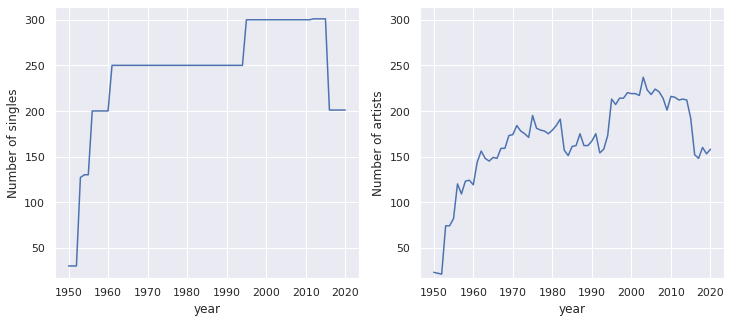

In [6]:
yearly_df = df.groupby('year')
plt.figure(figsize=(12, 5))

# Plots the number of titles per year
ax = plt.subplot(121)
yearly_titles = yearly_df.count()['title']
yearly_titles.plot(ax=ax)
ylim = ax.get_ylim()
plt.ylabel('Number of singles')

# Plots the number of unique artists per year
ax = plt.subplot(122)
yearly_df.artist.nunique().plot(ax=ax)
# Sets the same ylim as for the first plot
ax.set_ylim(ylim)

plt.ylabel('Number of artists')

## Missing data

In [7]:
def yearly_missing_info(df, country=None):
    """
    Returns a dataframe containing the number of titles, number of titles
    with complete lyrics, number of missing lyrics and the proportions of
    titles whose lyrics are missing.
    """
    # Filter by country if required
    if country is not None:
        df = df[df['country'] == country]
    
    yearly_df = df.groupby('year')
    # Yearly count of titles
    yearly_titles = yearly_df.count()['title']

    # Yearly count of songs with complete lyrics
    yearly_complete_lyrics = yearly_df.sum()['lyrics_state']
    # Yearly proportions of songs whose lyrics are not missing
    yearly_missing_proportion = 1 - (yearly_complete_lyrics / yearly_titles)

    yearly_df = pd.DataFrame({'titles_count': yearly_titles, 'complete': yearly_complete_lyrics, 'missing': yearly_titles - yearly_complete_lyrics,
                              'missing_proportion': yearly_missing_proportion})
    return yearly_df

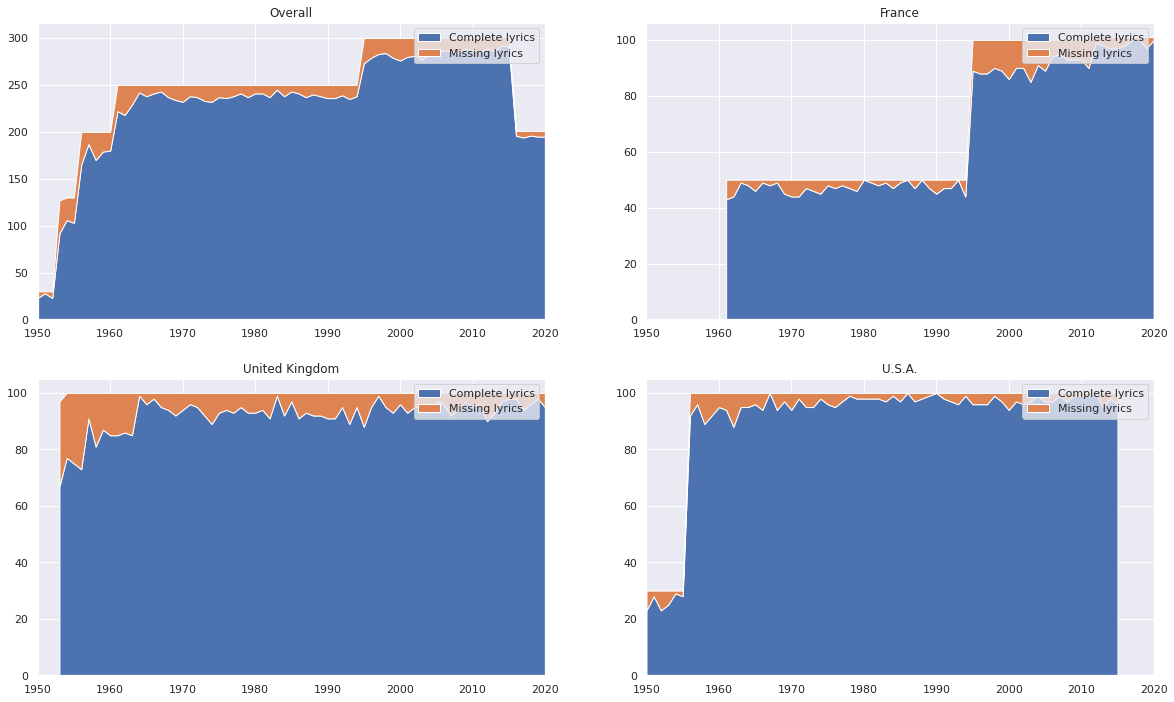

In [8]:
plt.figure(figsize=(20, 12))

def plot_missing_lyrics(ax, title, country=None):
    yearly_df = yearly_missing_info(df, country=country)
    plt.stackplot(yearly_df.index,
                  yearly_df['complete'], yearly_df['missing'],
                  baseline ='zero')
    plt.legend(['Complete lyrics', 'Missing lyrics'])
    plt.xlim(1950, 2020)
    ax.set_title(title)
    
# Plots the proportions of missing lyrics overall and separately for every country
ax = plt.subplot(221)
plot_missing_lyrics(ax, "Overall")
ax = plt.subplot(222)
plot_missing_lyrics(ax, "France", country="fr")
ax = plt.subplot(223)
plot_missing_lyrics(ax, "United Kingdom", country="uk")
ax = plt.subplot(224)
plot_missing_lyrics(ax, "U.S.A.", country="us")

plt.show()

## First cleaning
We first need to apply some basic cleaning on the lyrics. Let's print some of the lyrics:

In [9]:
# We discard the songs whose lyrics are missing
lyrics_df = df[df['lyrics_state'] == 1].drop('lyrics_state', axis=1)

In [10]:
lyrics_df.head()

,year,artist,title,lyrics,country
0,2005,tony christie ft peter kay,(is this the way to) amarillo,July 2020 Singles Release Calendar Lyrics7/1\n...,uk
1,2005,shayne ward,that's my goal,"That’s My Goal Lyrics\nYeah, you know where I'...",uk
2,2005,crazy frog,axel f,Axel F Lyrics\nRing ding ding daa baa\nBaa ara...,uk
3,2005,james blunt,you're beautiful,You’re Beautiful Lyrics\nMy life is brilliant\...,uk
4,2005,pussycat dolls ft busta rhymes,don't cha,"Don’t Cha Lyrics\nOkay (Ahh)\nYeah (Ahh)\nOh, ...",uk


We can first notice that all songs start with a line "SONG NAME Lyrics", which we should remove:

In [11]:
def remove_Lyrics_line(lyrics):
    """
    Removes the beginning of a song lyrics until the "Lyrics" word is found.
    """
    pos = lyrics.find('Lyrics')
    if pos != -1:
        return lyrics[pos + 6:]

In [12]:
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(remove_Lyrics_line)

## Non-songs items
Some items are not songs lyrics but list of songs, for some reason. This is admitted by the python GENIUS api and cannot be avoided as long as we use their api.

In [13]:
lyrics_lengths = lyrics_df['lyrics'].apply(lambda text: len(text.split(' ')))

Text(0.5, 0, "Number of words in the 'lyrics'")

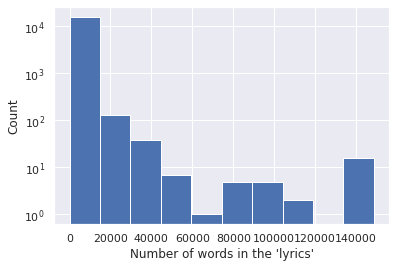

In [14]:
lyrics_lengths.hist(log=True)
plt.ylabel("Count")
plt.xlabel("Number of words in the 'lyrics'")

Over a hundred "songs" are longer than 20000 words, which is of course unrealistic. Actually it even contains memoires, such as "Angela's Ashes" by Frank McCourt.  
To remove those, we'll filter the songs whose lyrics are longer than an arbitrary limit, let's say 1000 words.

In [15]:
lyrics_df = lyrics_df[lyrics_lengths < 1000]

Text(0.5, 0, "Number of words in the 'lyrics'")

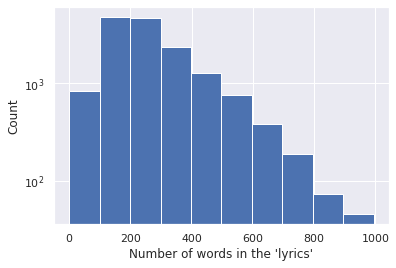

In [16]:
lyrics_lengths = lyrics_df['lyrics'].apply(lambda text: len(text.split(' ')))
lyrics_lengths.hist(log=True)
plt.ylabel("Count")
plt.xlabel("Number of words in the 'lyrics'")

# Language classification
We'll now need to detect the language of every song in order to run the LDA. To do so we don't need to divide the data
by country.  
We'll use the python module ```langdetect```.

## Detection

In [17]:
languages = []
# For every song, detect its language
for row, lyrics in zip(trange(lyrics_df.shape[0]), lyrics_df['lyrics']):
    languages.append(langdetect(lyrics))
lyrics_df['lang'] = languages

  0%|          | 0/15466 [00:00<?, ?it/s]

## Analysis
Let's first have a look at the songs which were detected as neither in french or english:

In [18]:
lyrics_df[~lyrics_df['lang'].isin(['fr', 'en'])]

,year,artist,title,lyrics,country,lang
2,2005,crazy frog,axel f,\nRing ding ding daa baa\nBaa aramba baa bom b...,uk,id
91,2005,franz ferdinand,do you want to,"\nOh, when I woke up tonight, I said I’m\nGoin...",uk,pt
93,2005,daddy yankee,gasolina,\n\nWho's this?\nDa-ddy Yan-kee!\n\nZúmbale ma...,uk,es
514,2010,lady gaga ft beyonce,telephone,"\nSelam, selam, bebeğim, sen mi aradın? Hiçbir...",uk,tr
537,2010,sidney samson ft wizard sleeve,riverside (let's go),Riverside motherfucker\nRiverside motherfucker...,uk,da
...,...,...,...,...,...,...
17129,1990,latino party,the party,Give yourself a little love\nUh! baby and give...,fr,es
17142,1991,crystal waters,gypsy woman (la da dee la da da),\nShe wakes up early every morning\nJust to do...,fr,nl
17161,1991,rem,shiny happy people,\nShiny happy people laughing\n\nMeet me in th...,fr,af
17216,1992,marco masini,perché lo fai,Con questa pioggia nei capelli perché lo fai\n...,fr,it


For now we'll discard those songs as they represent a tiny portion of the total dataset. Nonetheless this list contains errors (for example, Justin Bieber's "Baby" is counted as portuguese, becaused GENIUS.com returned a translation of the original lyrics for some reason).

In [19]:
lyrics_df.loc[~lyrics_df['lang'].isin(['fr', 'en']), 'lang'] = 'other'

Let's have a look at the languages distributions:

In [20]:
def yearly_lang_info(df, country=None):
    """
    Returns a dataframe containing the number of songs in each language
    found per year.
    """
    # Filter by country if required
    if country is not None:
        df = df[df['country'] == country]
    
    yearly_df = df.groupby(['year', 'lang'])
    lang_songs = yearly_df.count().rename({'title': 'title count'}, axis=1)

    return lang_songs['title count'].reset_index()

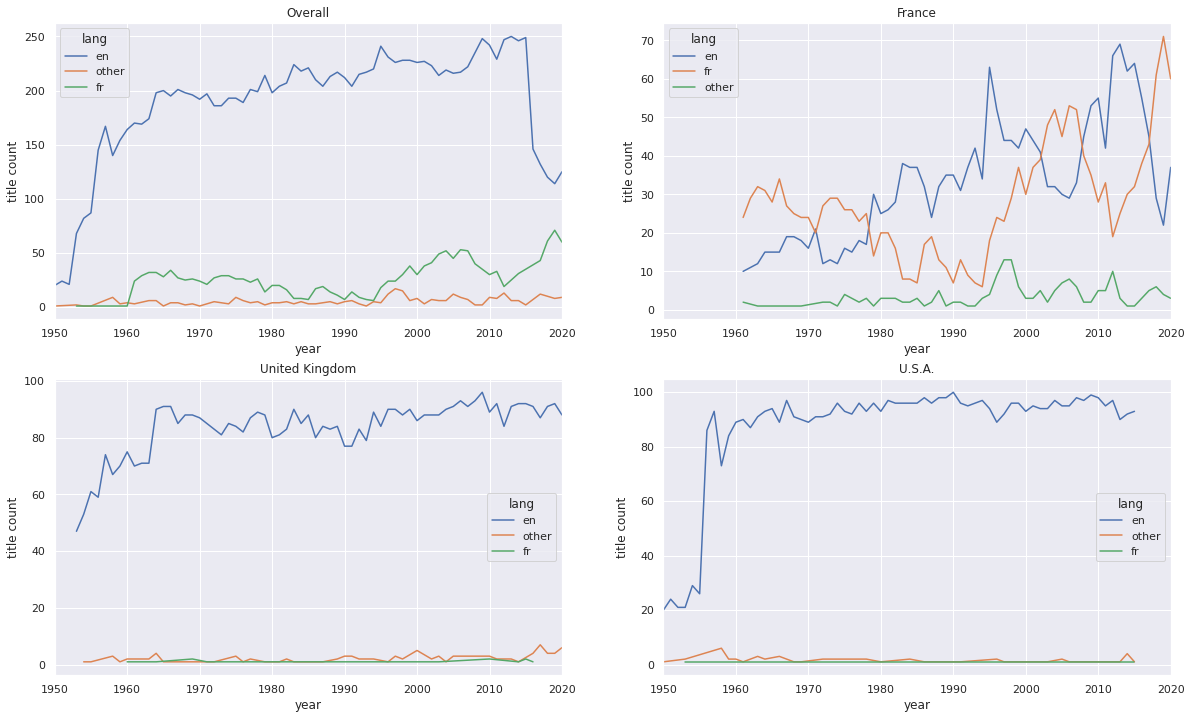

In [21]:
plt.figure(figsize=(20, 12))

def plot_lang_counts(ax, title, country=None):
    yearly_df = yearly_lang_info(lyrics_df, country=country)
    sns.lineplot(data=yearly_df, x="year", y="title count", hue="lang")
    plt.xlim(1950, 2020)
    ax.set_title(title)
    
# Plots the proportions of missing lyrics overall and separately for every country
ax = plt.subplot(221)
plot_lang_counts(ax, "Overall")
ax = plt.subplot(222)
plot_lang_counts(ax, "France", country="fr")
ax = plt.subplot(223)
plot_lang_counts(ax, "United Kingdom", country="uk")
ax = plt.subplot(224)
plot_lang_counts(ax, "U.S.A.", country="us")

plt.show()

## Saving results
As in the following we'll process the lyrics by streaming the data rather than all at once, we must sort the results by year before saving.

In [22]:
lyrics_df = lyrics_df.sort_values(by='year')
lyrics_df.to_csv('data/lang_lyrics_df.tsv', sep="\t")

# Topic modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycld2 as cld2
import gensim
import spacy
import nltk
from langdetect import detect as langdetect
from tqdm.notebook import trange, tqdm
from csv import DictReader, DictWriter
sns.set_theme()

## Text preprocessing using spaCy

The preprocessing involves the following steps:
* Tokenization
* Stopwords and punctuation removal
* Lemmatization  
* Non-english or Non-French words removal

Songs are neither in French or English will be ignored as we do not have enough of them to perform a meaningful analsysi, and we otherwise wouldn't be able to interpret the topics. For the former reason, we'll also skip songs that are in French but are not part of the France charts lists.

In [2]:
# We won't need the named entity recognition
excluded_components = ['ner']
nlp_en = spacy.load('en_core_web_sm', exclude=excluded_components)
nlp_fr = spacy.load('fr_core_news_sm', exclude=excluded_components)

We won't load all of the lyrics and process them at once as it would too memory-consuming for some devices (more than 20 GiB required).  
Instead, we'll stream process them using a csv ```DictReader```, and save the resulting strings using ```DictWriter```.  

In [3]:
with open('data/lang_lyrics_df.tsv', newline='') as lyrics_file:
    with open('data/processed_df.tsv', 'w', newline='') as save_file:
        reader = DictReader(lyrics_file, delimiter='\t')
        writer = DictWriter(save_file, delimiter='\t',
                            fieldnames=['year', 'artist', 'title', 'country', 'lang', 'doc'])
        writer.writeheader()
        for cnt, row in enumerate(reader):
            # Filters out the casual song lists
            if 'ft' in row['lyrics'] or ' - ' in row['lyrics'] or '@' in row['lyrics']:
                continue
            # Choose the right pipeline depending on the language
            if row['lang'] == 'en':
                # Apply the SpaCy NLP pipeline
                doc = nlp_en(row['lyrics'])
            # We do not take into account languages other than English or French, and we don't
            # either take into account songs in French that are part of the UK or US lists
            # as we don't have enough of them
            elif row['lang'] == 'fr' and row['country'] == 'fr':
                doc = nlp_fr(row['lyrics'])
            else:
                continue
            # Filters the token that are stopwords, punctuation or (multiple) line breaks
            doc = [token.lemma_.lower() for token in doc if not (token.is_stop or token.is_punct) and token.text[0] != '\n']
            # Saves the resulting document alongside the song's information
            # The doc is saved as a string of the tokens separated by white spaces
            writer.writerow({'year': row['year'], 'artist':row['artist'], 'title': row['title'],
                             'country': row['country'], 'lang': row['lang'],
                             'doc': ' '.join(doc)})
            if cnt % 500 == 0 and cnt > 0:
                print(f"Processed {cnt} songs")

Processed 500 songs
Processed 1000 songs
Processed 1500 songs
Processed 2500 songs
Processed 3500 songs
Processed 4500 songs
Processed 5000 songs
Processed 5500 songs
Processed 6000 songs
Processed 6500 songs
Processed 7000 songs
Processed 7500 songs
Processed 8000 songs
Processed 8500 songs
Processed 9000 songs
Processed 10000 songs
Processed 11000 songs
Processed 12000 songs
Processed 12500 songs
Processed 13000 songs
Processed 13500 songs
Processed 14000 songs
Processed 14500 songs
Processed 15000 songs


## Building the GENSIM corpus
We'll use GENSIM to perform the Dynamic Topic Modeling. We first need to create a Corpus object to contain vectors corresponding to the original documents (the lyrics).  
Fortunately gensim allows us to perform all of this as a streaming task, to avoid loading the whole dataset in RAM at any point.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim import corpora
from gensim.models import LdaSeqModel
from tqdm.notebook import trange, tqdm
from csv import DictReader, DictWriter
sns.set_theme()

### Dictionary
We'll first build the gensim Dictionary, which is an association between words and unique ids.  
Once again, we'll need to have two dictionaries, one for English and one for French.  
Finally, we'll remove words that only appear once in the whole corpus.

In [16]:
# Once for English
with open('data/processed_df.tsv', 'r') as docs_file:
    reader = DictReader(docs_file, delimiter='\t')
    # Builds the dictionary by reading the successive docs from the preprocessed TSV file
    # Each doc was obtained from the lyrics of a single
    dictionary_en = corpora.Dictionary(row['doc'].lower().split() for row in reader if row['lang'] == 'en')

# Remove words that appear once in the corpus
once_ids = [tokenid for tokenid, docfreq in dictionary_en.dfs.items() if docfreq == 1]
dictionary_en.filter_tokens(once_ids)  
dictionary_en.compactify() 

In [17]:
# Once for French
with open('data/processed_df.tsv', 'r') as docs_file:
    reader = DictReader(docs_file, delimiter='\t')
    # Builds the dictionary by reading the successive docs from the preprocessed TSV file
    # Each doc was obtained from the lyrics of a single
    dictionary_fr = corpora.Dictionary(row['doc'].lower().split() for row in reader if row['lang'] == 'fr')

# Remove words that appear once in the corpus
once_ids = [tokenid for tokenid, docfreq in dictionary_fr.dfs.items() if docfreq == 1]
dictionary_fr.filter_tokens(once_ids)  
dictionary_fr.compactify() 

In order to reduce the dictionary size, which is a crucial factor in the computation time of the DTM, we'll only keep the most
frequent words:

In [18]:
dictionary_en.filter_extremes(keep_n=3000)
dictionary_fr.filter_extremes(keep_n=3000)

### Corpus
We can now obtain the corpus, i.e. the Bag-Of-Words vectors associated to each song.  
We'll have a corpus for each country, and two for France to separate songs in French and in English.

In [19]:
class UKCorpus:
    def __iter__(self):
        with open('data/processed_df.tsv', 'r') as docs_file:
            reader = DictReader(docs_file, delimiter='\t')
            for row in reader:
                if row['country'] == 'uk':
                    yield dictionary_en.doc2bow(row['doc'].lower().split())
                    
class USCorpus:
    def __iter__(self):
        with open('data/processed_df.tsv', 'r') as docs_file:
            reader = DictReader(docs_file, delimiter='\t')
            for row in reader:
                if row['country'] == 'us':
                    yield dictionary_en.doc2bow(row['doc'].lower().split())


class FR_EN_Corpus:
    def __iter__(self):
        with open('data/processed_df.tsv', 'r') as docs_file:
            reader = DictReader(docs_file, delimiter='\t')
            for row in reader:
                if row['country'] == 'fr' and row['lang'] == 'en':
                    yield dictionary_en.doc2bow(row['doc'].lower().split())
                    
class FR_FR_Corpus:
    def __iter__(self):
        with open('data/processed_df.tsv', 'r') as docs_file:
            reader = DictReader(docs_file, delimiter='\t')
            for row in reader:
                if row['country'] == 'fr' and row['lang'] == 'fr':
                    yield dictionary_fr.doc2bow(row['doc'].lower().split())

In [20]:
corpus_uk = UKCorpus()
corpus_us = USCorpus()
corpus_fr_en = FR_EN_Corpus()
corpus_fr_fr = FR_FR_Corpus()

## GENSIM LdaSeqModel

### Computing the time slices
We need to know the years that our data spans, but also how many songs are given for each year. This is also the step where we'll start dividing the data per country.

In [21]:
# We have to load the pandas dataset
lyrics_df = pd.read_csv('data/processed_df.tsv', sep='\t')
# Filters the language: Keeps only English, or French for songs from the France list
lyrics_df = lyrics_df[(lyrics_df['lang'] == 'en') | ((lyrics_df['lang'] == 'fr') & (lyrics_df['country'] == 'fr'))]
lyrics_df.head()

,year,artist,title,country,lang,doc
0,1950,frankie laine,cry of the wild goose,us,en,chorus frankie laine heart know wild goose kno...
1,1950,bing crosby,dear hearts and gentle people,us,en,love dear heart gentle people live hometown de...
2,1950,billy eckstine,my foolish heart,us,en,night like lovely tune beware foolish heart wh...
3,1950,ames brothers,can anyone explain?,us,en,explain thrill kiss eager lip press know yes k...
4,1950,perry como,hoop-dee-doo,us,en,hoop dee doo hoop dee doo hear polka trouble h...


In [22]:
uk_df = lyrics_df[lyrics_df['country'] == 'uk']
us_df = lyrics_df[lyrics_df['country'] == 'us']
fr_en_df = lyrics_df[(lyrics_df['country'] == 'fr') & (lyrics_df['lang'] == 'en')]
fr_fr_df = lyrics_df[(lyrics_df['country'] == 'fr') & (lyrics_df['lang'] == 'fr')]

The time slices are simply the number of documents for each time period (ie singles per year).

In [23]:
def singles_per_year(df):
    return df.groupby('year').count().rename({'title': 'count'}, axis=1)['count']

In [24]:
slices_uk = singles_per_year(uk_df)
slices_us = singles_per_year(us_df)
slices_fr_en = singles_per_year(fr_en_df)
slices_fr_fr = singles_per_year(fr_fr_df)

### Applying the LdaSeqModel

In [25]:
ldaseq_uk = LdaSeqModel(corpus=corpus_uk, id2word=dictionary_en, time_slice=slices_uk)

KeyboardInterrupt: 

In [ ]:
ldaseq_us = LdaSeqModel(corpus=corpus_us, id2word=dictionary_en, time_slice=slices_us)

In [ ]:
ldaseq_fr_fr = LdaSeqModel(corpus=corpus_fr_en, id2word=dictionary_en, time_slice=slices_fr_en)

In [ ]:
ldaseq_fr_fr = LdaSeqModel(corpus=corpus_fr_fr, id2word=dictionary_fr, time_slice=slices_fr_fr)

## BERTopic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from tqdm.notebook import trange, tqdm
from csv import DictReader, DictWriter

In [2]:
processed_df = pd.read_csv('data/processed_df.tsv', sep='\t')
processed_df['year'] = pd.to_datetime(processed_df['year'], format="%Y")
# Removes all docs that contain lists of songs rather than actual lyrics
processed_df = processed_df[~processed_df['doc'].str.contains(' ft ')]
processed_df.head()

,year,artist,title,country,lang,doc
0,1950-01-01,frankie laine,cry of the wild goose,us,en,chorus frankie laine heart know wild goose kno...
1,1950-01-01,bing crosby,dear hearts and gentle people,us,en,love dear heart gentle people live hometown de...
2,1950-01-01,billy eckstine,my foolish heart,us,en,night like lovely tune beware foolish heart wh...
3,1950-01-01,ames brothers,can anyone explain?,us,en,explain thrill kiss eager lip press know yes k...
4,1950-01-01,perry como,hoop-dee-doo,us,en,hoop dee doo hoop dee doo hear polka trouble h...


In [3]:
uk_corpus = processed_df[(processed_df['country'] == 'uk') & (processed_df['lang'] == 'en')]

In [4]:
uk_lyrics = uk_corpus['doc'].to_list()
uk_dates = uk_corpus['year'].to_list()

In [25]:
uk_dtm = BERTopic(min_topic_size=100, verbose=True)
uk_topics, _ = uk_dtm.fit_transform(uk_lyrics)

Batches:   0%|          | 0/177 [00:00<?, ?it/s]

2022-05-21 11:16:47,067 - BERTopic - Transformed documents to Embeddings
2022-05-21 11:16:52,066 - BERTopic - Reduced dimensionality
2022-05-21 11:16:52,472 - BERTopic - Clustered reduced embeddings


In [26]:
freq = uk_dtm.get_topic_info()
freq

,Topic,Count,Name
0,-1,2293,-1_oh_love_know_baby
1,0,1833,0_love_know_oh_time
2,1,1513,1_yeah_oh_like_get


In [27]:
uk_dtm.visualize_topics()
plt.savefig('figs/topics.png')

ValueError: zero-size array to reduction operation maximum which has no identity

In [7]:
topics_over_time = uk_dtm.topics_over_time(docs=uk_lyrics, 
                                                topics=uk_topics, 
                                                timestamps=uk_dates, 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=20)

20it [00:01, 17.69it/s]


In [10]:
fig = uk_dtm.visualize_topics_over_time(topics_over_time, top_n_topics=20)

In [14]:
plt.savefig('figs/topics.png')

<Figure size 432x288 with 0 Axes>